In [27]:
#!pip install pystoi STOI score
# !pip install soundfile
# installer PESQ score (il faut une certaine version de numpy)

import os
import soundfile as sf
import torch
import matplotlib.pyplot as plt
import numpy as np 
import scipy
import scipy.signal
import IPython.display as ipd


# PROJET : Audio Denoising

## Elèves
>(Léa, Bohbot)
>(Valentine, Tosel)

## Consignes
Pour ce projet vous avez :

Pour le train 
- Un dossier contenant des fichiers d'enregistrements de voix sans bruit (audio/voice_origin/train)
- Un dossier contenant des fichiers d'enregistrements de voix avec une ambiance de rue en arrière-plan (audio/denoising/train)
La correspondance entre un enregistrement avec ambiance et l'enregistrement parfait de la voix se fait via le nom des fichiers. 

Pour l'ensemble de test vous avez deux ensembles de fichiers similaires. 

Dans audio/voice_origin et audio/denoising vous avec un dossier train_small de petite taille que vous pouvez télécharger rapidement pour faire des essai. 

L'objectif est d'estimer à partir du signal bruité le signal de voix. 

Les signaux ont un SNR (Signal to Noise Ratio) compris entre 0 et 20 dB. 

Vous pouvez au choix travailler 
- sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours 08 et en estimant les masques avec un réseau **Seq2Seq** de votre choix ou un **UNet** (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  : 
   - cf D. Stoller  et Al., **WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION**, ISMIR 2018
   - les approches **TAS NEt** : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.


Libre à vous de choisir la **fonction de perte** utilisée dans l’entraînement et adaptée au format des données que vous utiliserez en entrée du réseau de neurones. 

**Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.**  


## Chargement des données

Nous avons trois jeux de données "train" , "train_small" et "test". On visualise dans un premier temps les données de "train_small".
Ce sont des fichiers .wav, pour lesquels on stocke le signal et la fréquence correspondante dans des tableaux numpy.
Nous utiliserons la librairie librosa de Python pour manipuler et visualiser les données.


In [28]:
small_data_path = r"C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small"

In [29]:
small_signals = []
small_f_echs = []
small_file_names = []

for file in os.listdir(small_data_path):
    filepath = os.path.join(small_data_path, file)
    print(filepath)
    signal, sr = sf.read(filepath)
    signal = signal/np.max(np.abs(signal)) #Pour normaliser voir si on garde ou pas
    signal/=np.std(signal)
    small_signals.append(signal)
    small_f_echs.append(sr)
    small_file_names.append(file)


C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_1_.wav
C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_2_.wav
C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_3_.wav
C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_4_.wav
C:\Users\valen\Documents\Travail\X\MVA\S1\Image Denoising\projet_audio_denoising\PROJET_TDS\with_noise\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_

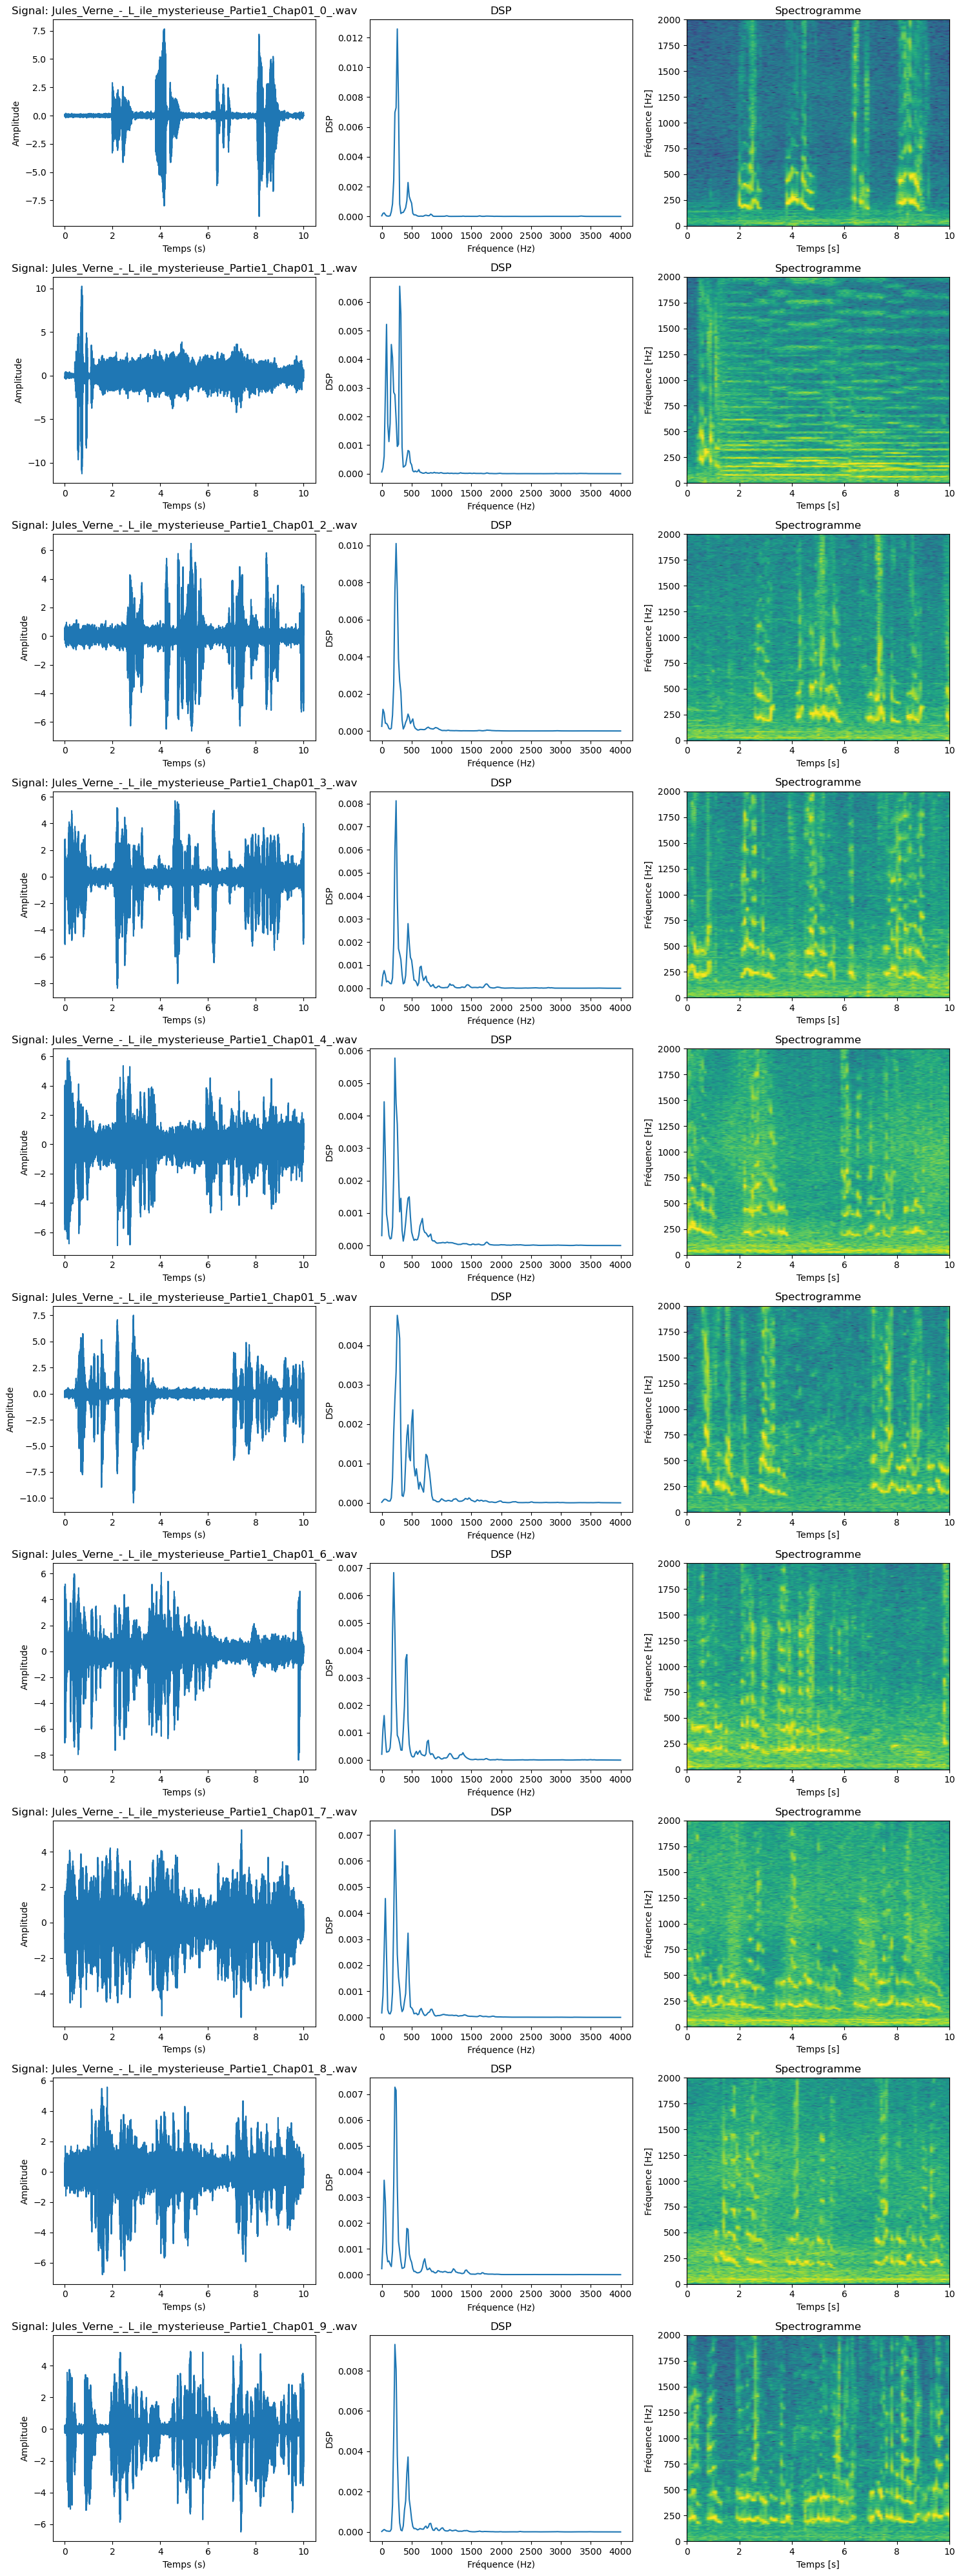

In [30]:
n = len(small_file_names)
fig, axes = plt.subplots(n, 3, figsize=(15, 4 * n))
for i in range(n):
    fe=small_f_echs[i]
    x = small_signals[i]
    t = np.arange(0,len(x)/fe,1/fe)

    #Signal
    axes[i, 0].plot(t,x)
    axes[i, 0].set_title(f"Signal: {small_file_names[i]}")
    axes[i, 0].set_xlabel("Temps (s)")
    axes[i, 0].set_ylabel("Amplitude")
    
    #DSP
    ff, dsp = scipy.signal.welch(x, fs=fe, nperseg=fe//20)
    axes[i, 1].plot(ff, dsp)
    axes[i, 1].set_title('DSP')
    axes[i, 1].set_xlabel('Fréquence (Hz)')
    axes[i, 1].set_ylabel('DSP')

    #Spectrogramme
    duree_segment= 0.2 # s
    nperseg= int(duree_segment *fe)
    f, t, Zxx = scipy.signal.stft(x, fe, nperseg=nperseg, noverlap=nperseg//2)
    axes[i, 2].pcolormesh(t, f, 20*np.log10(np.abs(Zxx)), vmax = -10,  vmin=-100,shading='gouraud')
    axes[i, 2].set_title('Spectrogramme')
    axes[i, 2].set_ylabel('Fréquence [Hz]')
    axes[i, 2].set_xlabel('Temps [s]')
    axes[i, 2].set_ylim([0,2000])

plt.tight_layout()
plt.show()

Les signaux les plus bruités se reconnaissent visuellement par un spectrogramme bruité, et une absence de moment de "silence" (d'amplitude basse) dans le signal audio. L'impact sur la DSP n'est en revanche pas très visible.

L'aspect étrange du deuxième signal vient du fait qu'il n'y a pas de voix mais une musique dans une grande partie de l'audio. 

### Débruitage grossier : filtre de Wiener


Audio 4
Version originale
Version débruitée


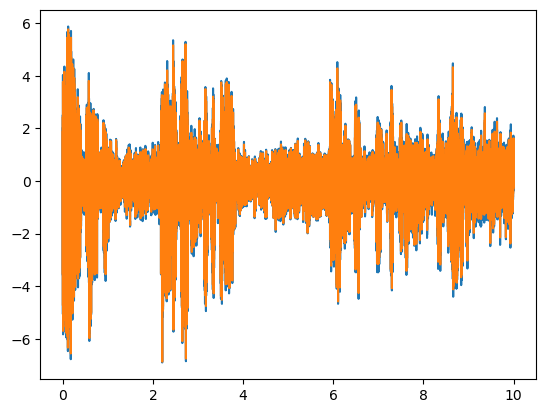

In [31]:
small_wiener_signals = []
for i in range(n) :
    signal = small_signals[i]
    denoised = scipy.signal.wiener(signal)
    small_wiener_signals.append(denoised)
print("Audio 4")
print("Version originale")
ipd.Audio(small_signals[4], rate=small_f_echs[4])

print("Version débruitée")
ipd.Audio(small_wiener_signals[4], rate=small_f_echs[4])

fe=small_f_echs[4]
x = small_signals[4]
t = np.arange(0,len(x)/fe,1/fe)
plt.plot(t,x)
plt.plot(t, small_wiener_signals[4])
plt.show()

## Débruitage avancé

###

Différentes métriques présentées dans le cours : MSE, SNR / SI-SNR, fonctions de perte du spectrogramme, métriques MOS (subjective), STOI et PESQ (objectives).

Voyons dans un premier temps ce que donne le débruitage classique par filtre de Wiener. 


